In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('CC_GENERAL.csv',index_col='CUST_ID')
df.head()
# after verifying CUST_ID is indeed a unique identifier, we set it as our index
# df['CUST_ID'].nunique() == df.shape[0]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## what is this dataset?

source: kaggle

describes the behavior of about 9000 credit holders over a period of 6 months.

it includes 18 features.

## what can we use this data for?

a bunch of things!

- we can use this data to simply learn more about our customers...no specific objective rather than building our intuitions about customer behavior.
- looking for anomolous behavior -- customers whose behavior is out of the ordinary (this is a modeling task, although we can start out by sleuthing directly)
- clustering or segmenting customers based on their behavior (there's overlap between this task and the anomaly detection task described in the previous bullet)
- we can choose a variable of interest from among the 18 features - and model it as a function of other variables. said another way, we could turn this into a _supervised_ learning task.

## let's cluster

- first we start with some light eda (exploratory data analysis)

- eda will probably uncover some data wrangling/data processing tasks, which we'll take head on

- then we'll take a shot at clustering

In [4]:
print(f"we have {df.shape[0]} rows and {df.shape[1]} columns")

we have 8950 rows and 17 columns


In [5]:
df.info() # gasp! null values


<class 'pandas.core.frame.DataFrame'>
Index: 8950 entries, C10001 to C19190
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CRED

## impute null values

In [6]:
df.isna().sum()[df.isna().sum() > 0]

CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64

In [7]:
# it's annoying that the column names are all caps, let's change that.
df.columns = [col.lower() for col in df.columns]

In [8]:
# visual inspection of observations with missing minimum payments
df.loc[df['minimum_payments'].isna(),:].head(3)

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
CUST_ID,,,,,,,,,,,,,,,,,
C10004,1666.670542,0.636364,1499.0,1499.0,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.0,NaN,0.0,12
C10047,2242.311686,1.000000,437.0,97.0,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.0,NaN,0.0,12
C10049,3910.111237,1.000000,0.0,0.0,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.0,NaN,0.0,12


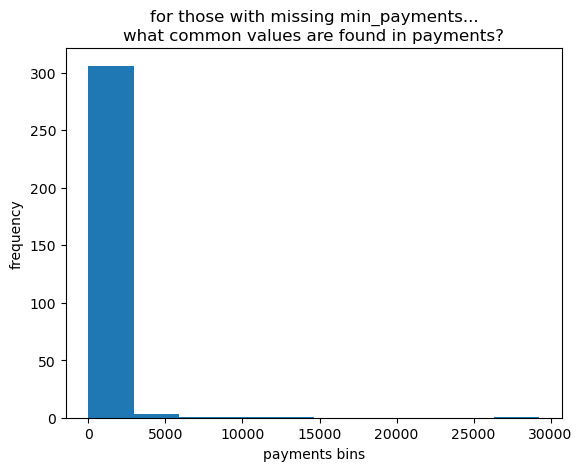

In [9]:
plt.plot()
plt.hist(df.loc[df['minimum_payments'].isna(),'payments'])
plt.xlabel("payments bins")
plt.ylabel("frequency")
plt.title("for those with missing min_payments...\nwhat common values are found in payments?")
plt.show()


In [10]:
# we think there's a connection between having a missing min payment and a payments of 0
mask = (df['minimum_payments'].isna()) & (df['payments'] == 0)
round(df.loc[mask,:].shape[0]/313,3)

0.767

we're going to impute min payments...and we can take a number of different approaches

- just take the average or median of min payment data that we do have, and impute using that
- throw away the rows with missing data

we'd probably be justified in doing that here because the proportion of missing data is relat, but that's no fun

- model based imputation (from very simple to very complex)

example of a simple approach: **constant of proportionality**
1. find another one of the features that is highly correlated with min payments (e.g. `payments`)
2. take the ratio `avg(min payments)/avg(payments) = C`
3. and let missing min payments be defined as `payments*C`

a little bit of algebra:

payments*C = min payments

C = min payments / payments 

think of this as "baby" linear regression

you can of course actually do a regression and impute using that

In [11]:
df.corr()['minimum_payments'].abs().sort_values(ascending = False)[:5]
# we take absolute values here becuase we don't care about the direction of the relationship

minimum_payments     1.000000
balance              0.398684
prc_full_payment     0.140379
cash_advance         0.140107
balance_frequency    0.132569
Name: minimum_payments, dtype: float64

In [12]:
# constant of proportionality between balance and min payments
# avg(min payments)/avg(balance)
c = df['minimum_payments'].mean()/df['balance'].mean()
imputed_min_payments = c*df.loc[df['minimum_payments'].isna(),'balance']
print(imputed_min_payments.mean(), df['minimum_payments'].mean())

306.822465338347 864.2065423050828


very quickly (we don't want to get bogged down) let's try to impute with linear regression too. 

In [13]:
# import our model class
# get the data ready
from sklearn.linear_model import LinearRegression
predictors = df.loc[~df['minimum_payments'].isna(),:].copy()
predictors.dropna(inplace=True)
target = predictors['minimum_payments'].copy()
predictors.drop(columns = ['minimum_payments'],inplace = True)
print(predictors.shape[0] == target.shape[0]) # let's just make sure our dimensions match

True


pause - before i make the model..how do we know if the model is any good once we make it?

do you guys know the basics of model evaluation for linear regression?

R squared is a common approach.

briefly:

a few hand-wavy ways of defining it are:
- "amount of the variance explained"
- "how much better is your model compared to the dummy model of always predicting the mean"

864 is the mean minimum payments -- consider that a naive "model" of minimum payments is to always predict 864.

so what does this mean? an r-squared of 0 is like always predicting the mean - and the closer you get to r2 of 1, is how much better you are than the mean.

In [14]:
# fit the model
lm1 = LinearRegression()
lm1.fit(predictors,target)
# calculate r-squared
lm1.score(predictors,target)

0.19672360257016308

clearly we get better predictions than if we were to use the naive model.

so now the question is...

is this better than the approach that uses a constant of proportionality?


In [15]:
# calculate R squared for constant of proportionality 
# i need ground truth minimum_payments (known values of minimum payments) = y
# i also need values of minimum_payments calculated using C*balance = y_hat
# Rsquared(y,y_hat) -> we get out a value
from sklearn.metrics import r2_score
predicted_minimum_payments_using_cop = c*df.loc[(~df['minimum_payments'].isna()) & (~df['credit_limit'].isna()),'balance']
r2_score(target,predicted_minimum_payments_using_cop)

0.1509017635738128

yup it seems the regression is a better imputation strategy

we need to now generate predicted values of minimum_payments for the cases where minimum_payments is null using the regression model. once we have these, we can impute them into our table.

In [16]:
# create predictor matrix (table) by filtering data for cases where minimum_payments is null
predictors_imputation = df.loc[df['minimum_payments'].isna(),:].drop(columns = ['minimum_payments'])
# ^^^ and drop minimum_payments column
# generate predictions
imputed_minimum_payments_using_lm = lm1.predict(predictors_imputation)

In [17]:
# overwrite the nulls in df with these 313 values
df.loc[df['minimum_payments'].isna(),'minimum_payments'] = imputed_minimum_payments_using_lm

In [18]:
print(f"total null values in data frame {df.isna().sum().sum()}")

total null values in data frame 1


In [19]:
# that pesky credit limit missing value - drop it like its hot
df.dropna(inplace=True)

### inspect distributions, scale the data, check for the presence of extreme values

one important intuition about clustering is the following:

we will often transform our data to make it more amenable to clustering, make it less interpretable (scaling, log transforms etc.) but this is *totally fine*

once we have cluster labels, we can map them back to the original data that we know how to interpret.



to-do

1. visual inspection (make a bunch of histograms)
2. note the presence of outliers
3. we need to ensure the data is on the same scale.
4. decide how to scale the data (normalize (0-1), standardize (map to normal distribution), ....)

/var/folders/g7/wg003dgd7td2scfxtm9wznth0000gn/T/ipykernel_53985/1946942696.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,6,i+1)


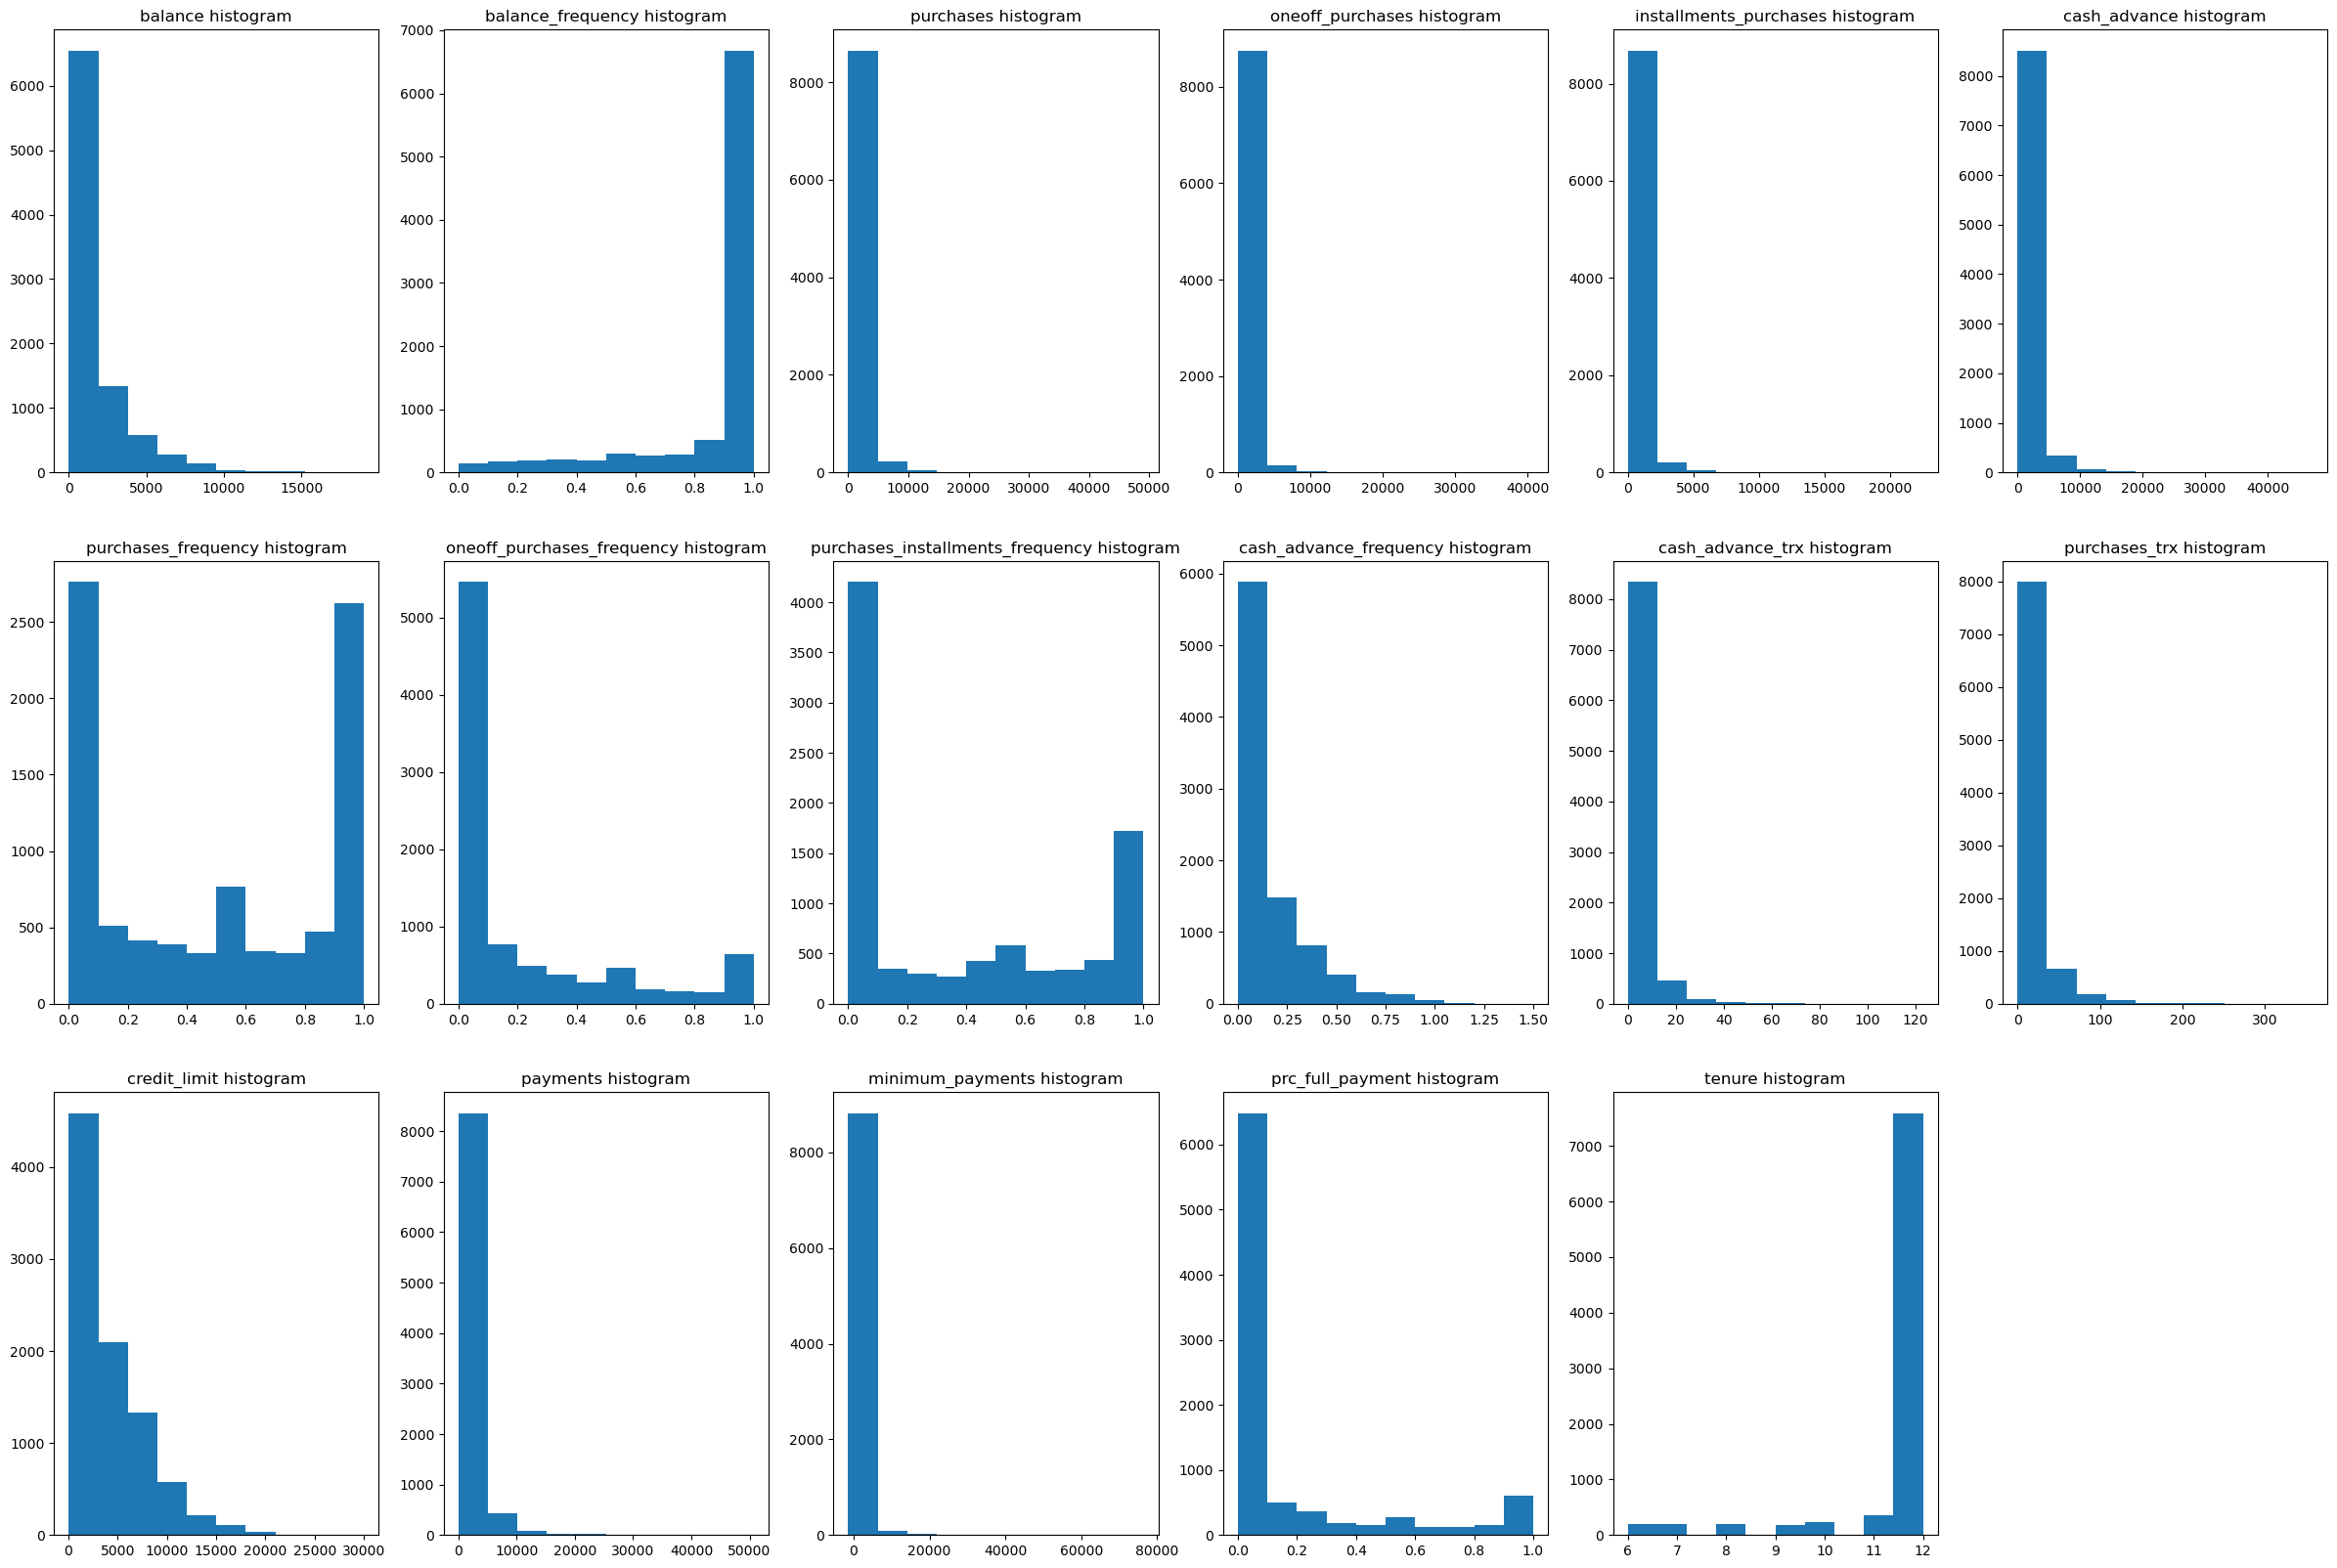

In [20]:
# make a bunch of histograms

plt.subplots(4,figsize = (30,20))

for i,col in enumerate(df.columns):
    plt.subplot(3,6,i+1)
    plt.hist(df[col])
    plt.title(f"{col} histogram")

plt.show()

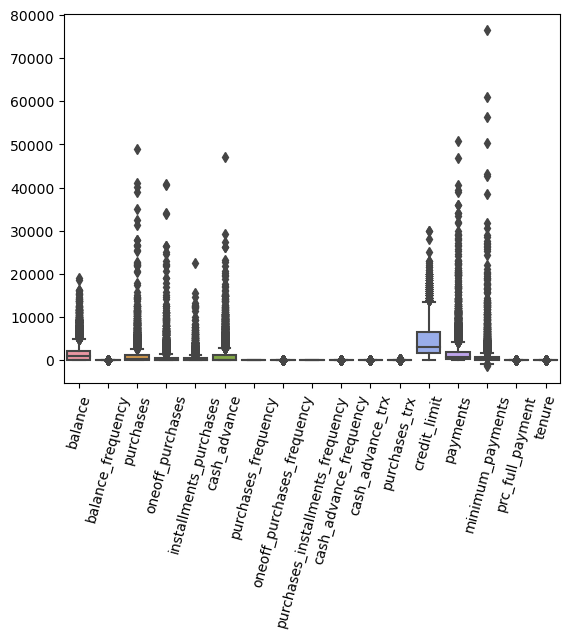

In [21]:
# here's another way to view our distributions
import seaborn as sns
fig, axis = plt.subplots(1,1)
sns.boxplot(df,ax = axis)
axis.tick_params(axis = 'x',rotation = 75)



this is super important:

the clustering algorithms we will use are **distance based**

similarity between data points (customers) will be determined by the distance between their vectors in our 17 dimensional feature space.

with this in mind, question:

why is it a problem that our data is on different scales?

...ok so we know it's a problem, so how do we scale our data?

options:

**minmax scaling**

suppose your data is `x = [100,39,203,...]`

`x_scaled = (x - x.min)/(x.max - x.min)`

imagine x is integers between 0 and 100

how does 0 translate to x_scaled?

`0 - 0/100 - 0 -> 0`

how does 100 translate to x_scaled?

`100 -> 1`

**standard scaler i.e. z-scoring**

hint - related to normal distribution - mean and standard deviation are the 2 numbers that characterize any normal distribution

suppose x is a variable in your dataset, we can calculate `mean(x) = mu`, `sd(x) = sigma`

standard scaling maps `mu -> 0` and `sigma -> 1`

`x_scaled = x - mean(x) / sd(x)`

**robust scaler - a lot like the standard scaler**

BUT instead centering (or subtracting) with the mean and dividing by sd

we use center with the median and divide by the IQR

IQR = the distance between the first quartile of the date (%25 percentile) and the 3rd quartile (%75 percentile)

`x_scaled = x - median(x)/IQR(x)`

look at the histograms above - i think we should use the robust scaler.

In [54]:
from sklearn.preprocessing import RobustScaler

# instantiate the thing (in this case the robustscaler)
scaler = RobustScaler()

# fit the thing (our scaler)
scaler.fit(df)

# transform the data using the thing
scaled = scaler.transform(df)

scaled = pd.DataFrame(scaled, columns = df.columns)

scaled.head(3)

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,-0.432387,-1.636364,-0.248596,-0.065763,0.013656,0.000000,-0.399999,-0.277777,-0.111112,0.000000,0.0,-0.3125,-0.408163,-0.431661,-0.265638,0.000000,0.0
1,1.209127,-0.818182,-0.337724,-0.065763,-0.189907,5.784296,-0.600000,-0.277777,-0.222223,1.125001,1.0,-0.4375,0.816327,2.138325,1.198697,1.555556,0.0
2,0.841881,0.000000,0.384615,1.272295,-0.189907,0.000000,0.600000,3.055557,-0.222223,0.000000,0.0,0.3125,0.918367,-0.154807,0.500059,0.000000,0.0


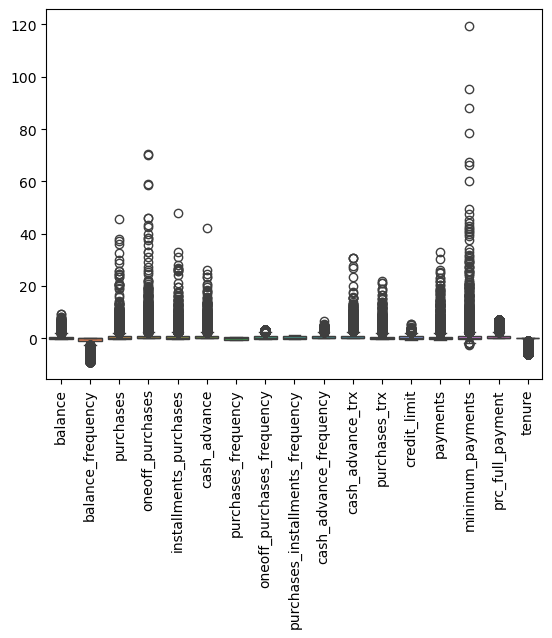

In [55]:
# hows our distribution looking?
fig, axis = plt.subplots(1,1)
sns.boxplot(scaled,ax = axis)
axis.tick_params(axis = 'x',rotation = 90)

outliers are killing us

we have tons of options for how to handle this.

i will advocate for *winsorization*

read more about it here: https://en.wikipedia.org/wiki/Winsorizing

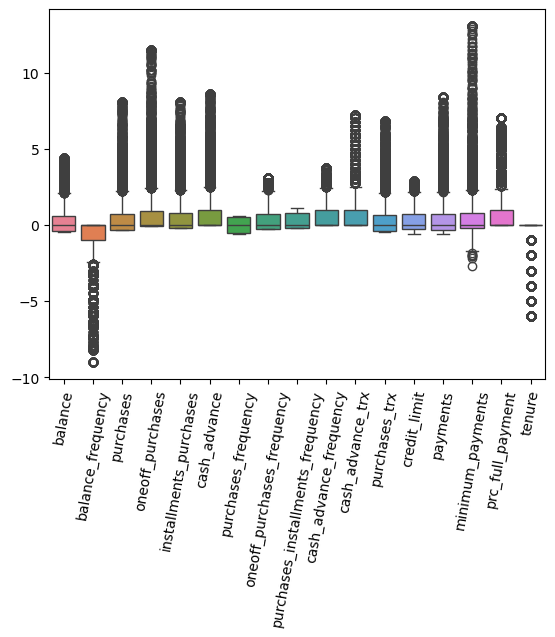

In [56]:
# cool - ready to force extreme values into a reasonable range
# winsorize to the 99th percentile -- if it turns out bad - no big deal
windsor = scaled.copy()
for col in windsor.columns:
    if np.max(windsor[col]) == 1.0:
        continue
    upper_limit = np.percentile(windsor[col],99)
    lower_limit = np.min(windsor[col])
    windsor[col] = np.clip(windsor[col],lower_limit,upper_limit)
    
fig, axis = plt.subplots(1,1)
sns.boxplot(windsor,ax = axis)
axis.tick_params(axis = 'x',rotation = 80)    

not bad for a first pass at preprocessing!

further iterations

- might include log transforming (prior to scaling) - not sure about this would need to try it both ways


## Clustering

first algo: K means

objective: find clusters (find groups of data points that are more similar to each other than they are to points in other groups)

how does K means work

1. you tell K means how many clusters we want it to find (that's the K parameter)
2. it will randomly generate K points in the feature space - these are the initial "cluster centers"
3. for every data point (every customer) we calculate the distance between them and each of the cluster centers
4. the data point is then assigned to the closest cluster center
5. for each cluster center, we reposition it by calculating the average of all the points that now belong to it
6. we repeat steps 3, 4 and 5, until the cluster centers no longer move.

at the end of this we have our clustering.


before we fit the model we need to talk about model evaluation.

*inertia* lets us quantify how good our clusters are

definition:

recall that every cluster has a cluster center -- so -- for every data point assigned to a cluster take the squared distance between it and the cluster center then add up these numbers.

simple example:
(5,18) = cluster center (c)
(4,17) and (3,16) are the two points in the cluster (p1,p2)
d(c,p1)^2 + d(c,p2)^2 = sum of squared distances

then... do this for all the other clusters

then... add up all of these numbers

that's inertia.

what's the intuition?

do we want inertia to be small or large in order to believe that we have good clusters?

we want inertia to be **small**

our procedure: experiment with the k parameter -- fit a kmeans for each value of k in a range of k that you want to experiment with, then graph k vs inertia. this is an example of a more general pattern in machine learning called hyperparameter optimization.

In [57]:
from sklearn.cluster import KMeans

ks, inertias = [], []

for k in range(1,11):
    # instantiate
    model = KMeans(n_clusters = k,n_init = 'auto')
    # fit
    model.fit(windsor)
    # score
    inertias.append(model.inertia_)
    ks.append(k)

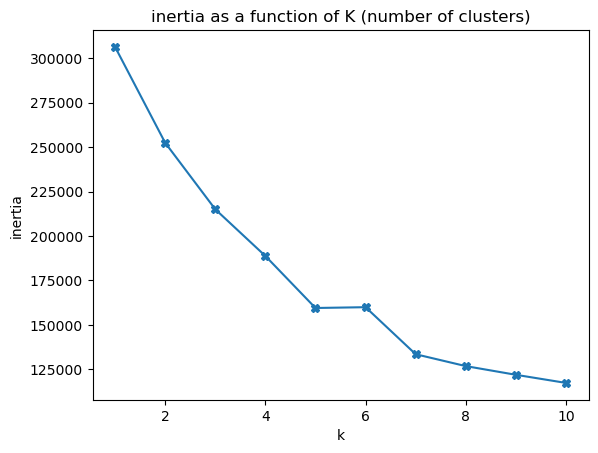

In [58]:
plt.figure()
plt.plot(ks,inertias,marker = "X")
plt.title("inertia as a function of K (number of clusters)")
plt.ylabel('inertia')
plt.xlabel('k')
plt.show()

In [59]:
# k = 5 <- this one looks the best
# k = 2
# k = 3

concordance between different models is an important idea in clustering - if different models agree on how data should be separated, it gives us confidence that the separations are meaningful.

we'll do agglomerative clustering next. this is a heirarchical approach - bottom up and iterative.

https://www.drive5.com/usearch/manual/agg.html
https://en.wikipedia.org/wiki/Hierarchical_clustering

there's no cluster centers (at least not defined naturally, or by the algo itself) because of this, we can't use inertia as a metric. luckily we have a different metric:

**silhouette score (sil score)**


for every point, we can calculate something called the sil coefficient - then we combine these to make up the sil score.

sil coefficient for a single data point `(p1)`

`a(p1)` = average distance between p1 and the other points in the cluster it belongs to
`b(p1)` = average distance between p1 and the points in the closest cluster that it does not belong to

`s(p1) = (b - a)/max(a,b)`

we calculate this coefficient for every single data point then we take the mean to get the sil score.

do we want the sil score to be large or small?

that's right - the **bigger** the better.


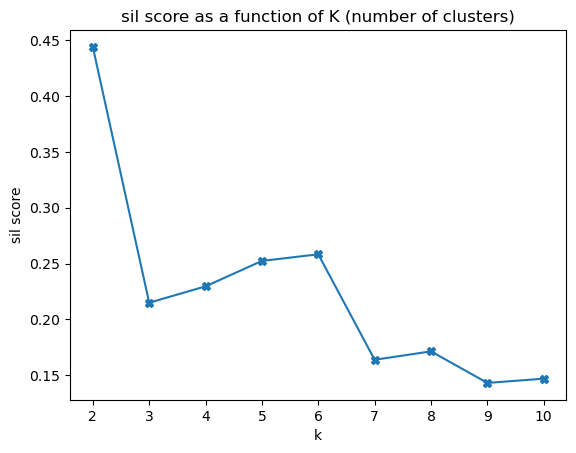

In [60]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

ks, sil_scores = [], []

for k in range(2,11):
    # instantiate
    model = AgglomerativeClustering(n_clusters = k)
    # fit
    model.fit(windsor)
    # score
    sil_score = silhouette_score(windsor,model.labels_)
    sil_scores.append(sil_score)
    ks.append(k)

plt.figure()
plt.plot(ks,sil_scores,marker = "X")
plt.title("sil score as a function of K (number of clusters)")
plt.ylabel('sil score')
plt.xlabel('k')
plt.show()

In [61]:
# we want to try 2 even though 5 is also looking pretty good

In [62]:
# let's go with 2
final_kmeans = KMeans(n_clusters = 2,n_init = 'auto')
final_kmeans.fit(windsor)

final_agglom = AgglomerativeClustering(n_clusters = 2)
final_agglom.fit(windsor)

AgglomerativeClustering()

In [63]:
# we will check for concordance - are they finding the same groups
# then we'll try to figure out what the clusters actually mean 
# in terms of customer behavior

In [64]:
# how do we check for agreement between clustering algorithms
# simple way
# what do cluster labels look like?
# kmeans_labels = (1,0,1,0,....)
# agglom_labels = (1,1,1,0,....)
# 2 x 2 table

# cluster labels (1 or 0) are superficial, arbitrary
# we just need to label the datapoints with something, anything...


print("original labels")
print(pd.crosstab(final_agglom.labels_,final_kmeans.labels_,rownames = ['agglom'],colnames = ['kmeans']))
print("table with the kmeans labels flipped (0 -> 1 and vice versa)")
print(pd.crosstab(final_agglom.labels_,(~final_kmeans.labels_.astype(bool)).astype(int),rownames = ['agglom'],colnames = ['kmeans']))

original labels
kmeans     0    1
agglom           
0       7870  553
1          4  522
table with the kmeans labels flipped (0 -> 1 and vice versa)
kmeans    0     1
agglom           
0       553  7870
1       522     4


In [65]:
print(f"percentage agreement between models: {np.round(100*(5895 + 509)/windsor.shape[0],1)}%")

percentage agreement between models: 71.6%


there is SOME amount of agreement between kmeans and agglom - 71% aggreement to be exact.

what would have been the worst thing to see (% agreement) and the best?

50% agreement is bad...it means essentially that knowing the label given by kmeans gives you no information about the agglomerative label.

other, more sophisticated measures of concordance?

- ARI (adjusted rand index)
- mutual information (MI) 

## visualization
to get a birds eye view of the clusters - an overall snapshot, we need to somehow reduce the dimensions of our dataset to 2 or 3 without losing too much info.

we could simply drop columns and visualize 2 or 3 of the more interesting combinations of columns but this throws away a lot of information...

if only there were a way to reduce dimensions without throwing away information.

good news...we have options.

In [66]:
# we are talking about data "compression"
# simple example: taking the mean of a list of numbers
# e.g. if you have a million numbers, and take the average of them, you're representing a million numbers using just a single number

# e.g.
# linear regression
# y ~ x
# y = f(x)
# y = f(x) = beta0 + beta1*x
# suppose y is a million numbers
# when you fit a model to y. how many numbers are you using to represent y???????
# 2 numbers to represent a million

# if you want to go down a rabbit hole
# this is related to something called 
# minimum description length principle (MDL)

In [67]:
# we can also compress columns

# how?

# PCA (principal component analysis)
# t-SNE 

how does t-SNE work (roughly)?

- start in original "feature space" (our 17 features about cc customers)
define a function that has output ranges between 0 and 1, and the function takes any two data points as its input.
- when data points are "close to eachother" the function returns a number closer to 1.
- t-SNE finds mappings between 17 dimensions and 2 dimensions
- it finds a lot of these mappings, but it wants to pick one.
- so just like it did in 17 dimensions, it will construct functions that take in pairs of data points and return number between 0 and 1
- it compares the function that takes 17-dim input, to the ones that take 2-dim input
- what does compare mean?
- it takes the distance between functions

finally, it returns the 2d representation that minimizes this distance.

In [68]:
from sklearn.manifold import TSNE

# instantiate tsne

tsne = TSNE()

# fit tsne

tsne_data = tsne.fit_transform(windsor)

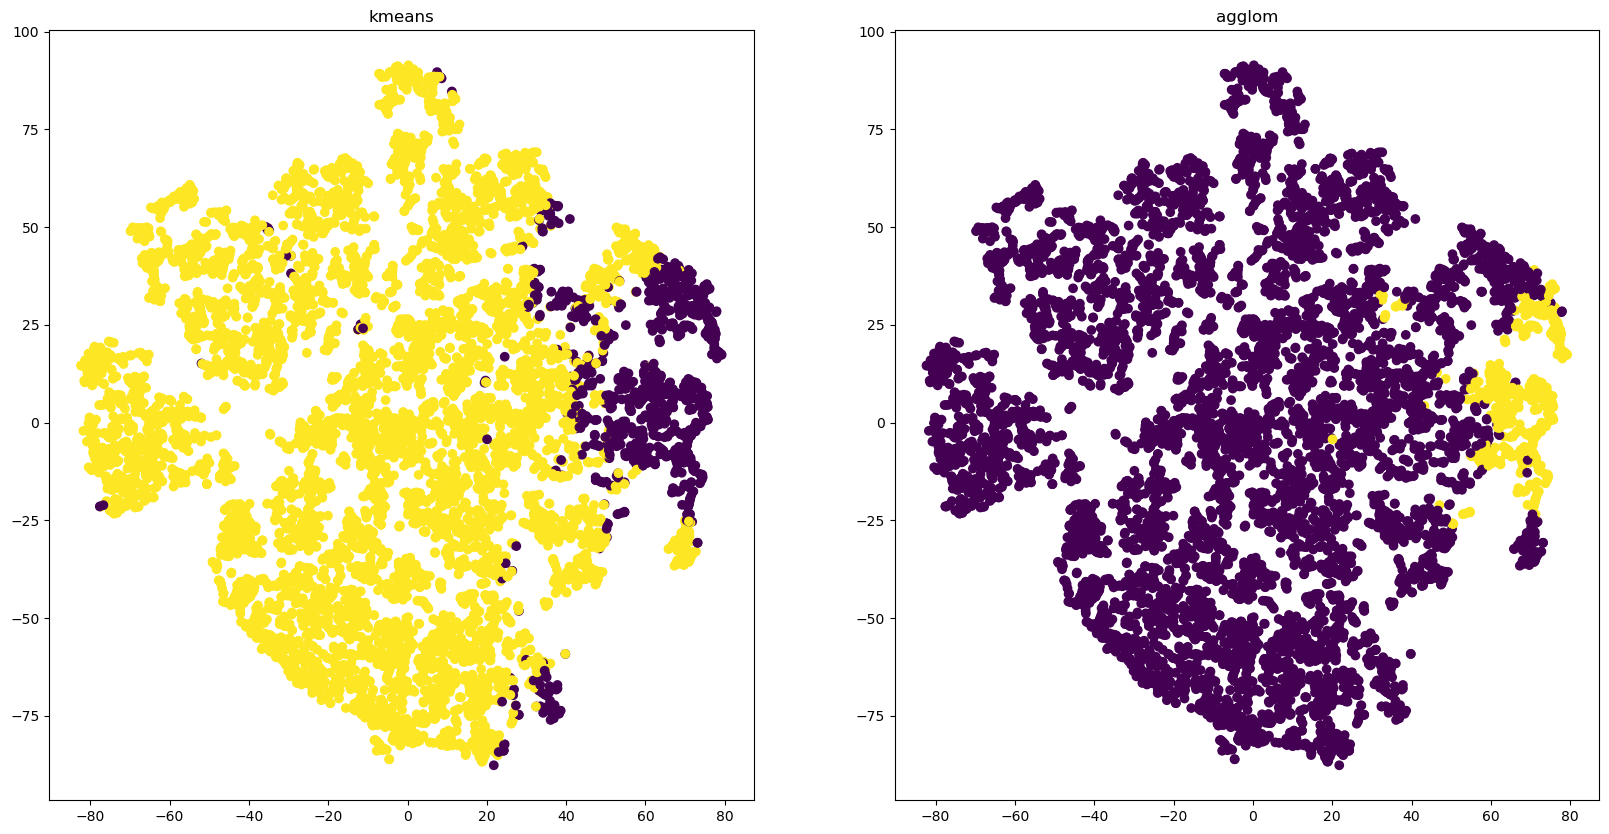

In [69]:
# visualize
plt.subplots(1,2,figsize = (20,10))
plt.subplot(1,2,1)
plt.scatter(tsne_data[:,0],tsne_data[:,1],c = (~final_kmeans.labels_.astype(bool)).astype(int))
plt.title("kmeans")
plt.subplot(1,2,2)
plt.scatter(tsne_data[:,0],tsne_data[:,1],c = final_agglom.labels_)
plt.title("agglom")
plt.show()


## Cluster evaluation (what does it all mean?)

In [70]:
# 1 . attach cluster labels back to original data
# 2 . and start doing EDA

df['kmeans'] = (~final_kmeans.labels_.astype(bool)).astype(int)
df['agglom'] = final_agglom.labels_

In [71]:
# start simple
# take descriptive stats (median/avg, ...)

# plots
# boxplots, pair plot (seaborn pair plot function), bar plots

# (inferential statistics for eda)
# are clusters statistically significantly different on the 16 numerical features

In [72]:
balance_diff = df.groupby(['kmeans']).describe()['balance'].T
balance_diff['ratio'] = balance_diff[1]/balance_diff[0]

In [73]:
np.round(balance_diff.loc[balance_diff.index == '50%','ratio'][0],2)

/var/folders/9f/pq8cvdd11_n8kt81_596lv3w0000gn/T/ipykernel_22286/816836809.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.round(balance_diff.loc[balance_diff.index == '50%','ratio'][0],2)


0.6

In [74]:
# group 1 has higher balances - that's a good insight!
# let's loop through all the columns

In [75]:
def column_compare(col):
    balance_diff = df.groupby(['kmeans']).describe()[col].T
    balance_diff['ratio'] = balance_diff[1]/balance_diff[0]
    
    ratio = np.round(balance_diff.loc[balance_diff.index == '50%','ratio'][0],2)

    print(f"for {col} the ratio of medians between group 1 and group 0 is: {ratio} ")

        

In [ ]:
for col in [col for col in df.columns if col != "kmeans"]:
    column_compare(col)

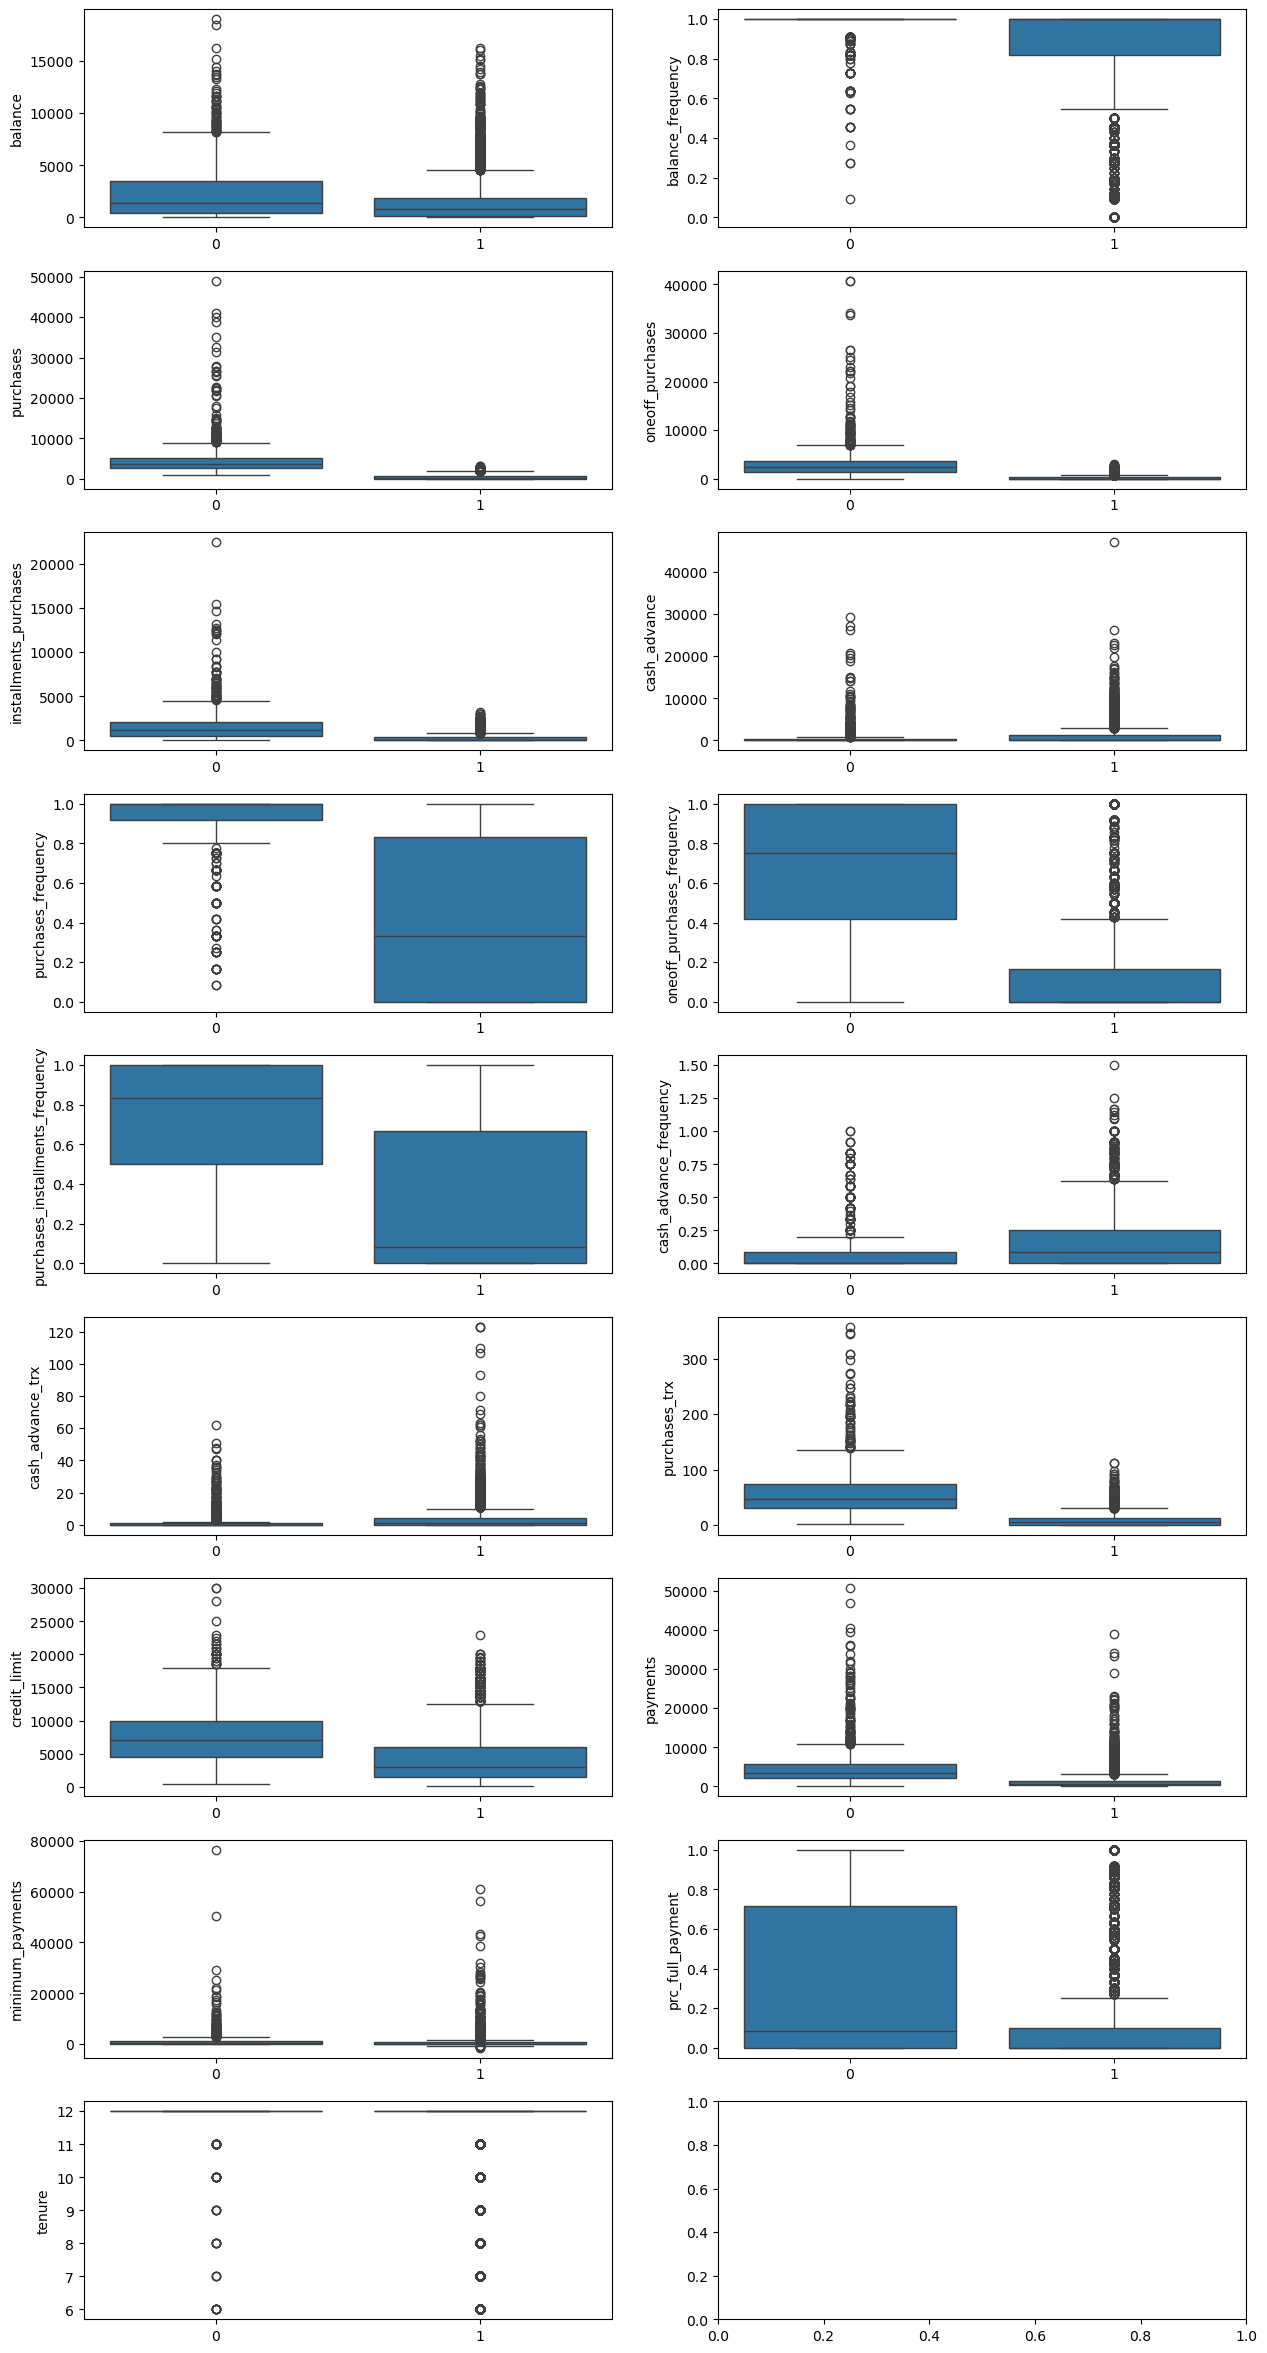

In [77]:
# do overlayed histograms / or boxplots
# comprehensive - a single grid of boxplots 8x2
import seaborn as sns

plt.subplots(9,2,figsize = (15,30))

for i, col in enumerate([col for col in df.columns if col not in ['kmeans','agglom']]):
    plt.subplot(9,2,i + 1)
    sns.boxplot(data=df, x="kmeans", y=col)
    plt.xlabel("")

plt.show()

lot's more work to be done to interpret cluster meanings...but it looks like we have identified 2 groups with vastly different credit risk.

**next steps and improvements**:

1. data processing
- we did not explore various transformations that might make the data easier to cluster. e.g. we have a lot of right skewed columns - can't we use log transformations?? yes
- was winsorization (clipping the data) really the best choice for handling outliers? maybe
- was using the RobustScaler the best choice for scaling? probably
= did we spoil/corrupt our data by imputing those 300 missing values? probably not, but maybe
2. modeling
- did we use the clustering algos best suited to the job? there's others we could explore
- did we pick a good number for n_clusters? depends on business needs really.

4. productization
- this notebook is a mess - in order to make this work useful..we need to modularize the code and build a service
